# Motifs pipeline

This notbooks shows how to use the Motif Pipeline. The Motif pipeline transforms a corpus to motif-based features, or other UDPipe tokens, such as POS, lemma, etc. It consists of 4 steps:
- UDPipe tokenization of the corpus
- tokens preprocessing with n-gram transformation
- n-grams featurization, for example: TFIDF or TF
- visualization, for example: PCA analysis, distributional plots, specificity analysis.

## Inputs variables

- `corpus_dir`: If you run this notebook for the first time, you need to pass
the corpus_dir as parameter in order to annotate the corpus and create the
tokens.
- otherwiswe, give the `tokens_dir` (output of the pipeline annotation and transformation into motifs) as argument.
- `token_type`: Define the token type of interest, `AVAILABLE_TOKEN_TYPES = ["text", "lemma", "pos", "motif"]`.
- `feature`: Define the feature on which to perform PCA analysis (see https://en.wikipedia.org/wiki/SMART_Information_Retrieval_System : `bnc`, `nfc`, `atu`, `lpb`).
- `n`: n-gram length of the sequence.

N.B. : by default, the package contains a test corpus available at this path : `PKG_DATA_PATH.joinpath('corpus_test')`. 

In [3]:
from motifs.config import PKG_DATA_PATH

# Define the path of the corpus
corpus_dir = PKG_DATA_PATH.joinpath('corpus_test')
tokens_dir = None
# tokens_dir = "../data/canon/tokens_canon"
# corpus_dir = None
# Define the token type: AVAILABLE_TOKEN_TYPES = ["text", "lemma", "pos", "motif"]
token_type = "motif"
# Define the feature on which to perform PCA analysis
feature = {"name": "tfidf", "params": {"normalize": True, "smartirs": "nfc"}}
# Please check gensim doc for the parameters definition. SMARTIRS
# corresponds to the standard notation available at https://en.wikipedia.org/wiki/SMART_Information_Retrieval_System
# n-gram length
n = 5

## Import librairies

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from motifs.pipeline import Pipeline
from motifs.plots import plot_motif_histogram, plot_tf_idf
from motifs.pca import pca_transform
import time

## Create pipeline object and perform annotation

The `Pipeline` function performs the annotation based on raw files (.txt) of the corpus directory and transform the corpus into the choosen `token_type`. The help() function gives documentation of the function and its parameters.

In [2]:
help(Pipeline)

Help on class Pipeline in module motifs.pipeline:

class Pipeline(builtins.object)
 |  Pipeline(token_type: str, tokens_dir: Optional[str] = None, corpus_dir: Optional[str] = None, docs: Optional[List] = None, save: bool = True, output_dir: Optional[str] = None, **kwargs)
 |  
 |  The Motif pipeline transforms a corpus to motif-based features, or other
 |  UDPipe tokens, such as POS, lemma, etc. It consists of 4 steps:
 |  - UDPipe tokenization of the corpus
 |  - tokens preprocessing with n-gram transformation
 |  - n-grams featurization, for example: TFIDF or TF
 |  - visualization, for example: PCA analysis, distributional plots,
 |  specificity analysis.
 |  
 |  :param token_type: type of the token to use for the analysis. Should be
 |  one of ["text", "lemma", "pos", "motif"]
 |  :param feature: Feature's configuration.
 |  :param tokens_dir: The folder where the tokens for each text is located.
 |  The tokens should be stored in a csv file obtained from `transform_corpus`
 |  of

In [4]:
pipeline = Pipeline(token_type, corpus_dir=corpus_dir, tokens_dir=tokens_dir, save=False)

Downloaded pre-trained UDPipe model for 'fr' language


[PyMotifs-Logger:tokenizer.py:299] - [348] - 2024-04-17 13:55:32 - DEBUG - Steps to go 3: tokenizing Huysmans-Rebours.txt...
[PyMotifs-Logger:tokenizer.py:317] - [348] - 2024-04-17 13:55:36 - DEBUG - Done with Huysmans-Rebours.txt in 3.38 seconds.
[PyMotifs-Logger:tokenizer.py:299] - [348] - 2024-04-17 13:55:36 - DEBUG - Steps to go 2: tokenizing Balzac-Goriot.txt...
[PyMotifs-Logger:tokenizer.py:317] - [348] - 2024-04-17 13:55:40 - DEBUG - Done with Balzac-Goriot.txt in 4.03 seconds.
[PyMotifs-Logger:tokenizer.py:299] - [348] - 2024-04-17 13:55:40 - DEBUG - Steps to go 1: tokenizing Flaubert-Bovary.txt...
[PyMotifs-Logger:tokenizer.py:317] - [348] - 2024-04-17 13:55:43 - DEBUG - Done with Flaubert-Bovary.txt in 3.55 seconds.


## Transform tokens to n-grams

The `transform_to_ngrams` function transforms the annotated corpus into motifs of n-grams length. The parameter is the length of the sequence you want (ngrams).

In [10]:
t1 = time.time()
# Transform to n_grams
pipeline.transform_to_ngrams(n)
t2 = time.time()
print(f"Execution time: {t2 - t1:.4f} secs")

Execution time: 1.0996 secs


[PyMotifs-Logger:features.py:49] - [808] - 2024-04-17 13:59:28 - DEBUG - Steps to go 2
[PyMotifs-Logger:features.py:49] - [912] - 2024-04-17 13:59:28 - DEBUG - Steps to go 1
[PyMotifs-Logger:features.py:49] - [807] - 2024-04-17 13:59:28 - DEBUG - Steps to go 3


## Simple statistics

### Number of tokens per document

In [15]:
help(plot_motif_histogram)

Help on function plot_motif_histogram in module motifs.plots:

plot_motif_histogram(ngrams: pandas.core.frame.DataFrame, stat: str = 'count', n_tokens: int = 15, plot_type: str = 'group')
    :param ngrams: DataFrame of ngrams tokens with columns: ["token", "doc"]
    :param stat: One of ["count", "proportion", "percent"]
    :param n_tokens: Max number of tokens to plot
    :param plot_type:
    :return:



Text(0.5, 1.0, 'Number of tokens per document')

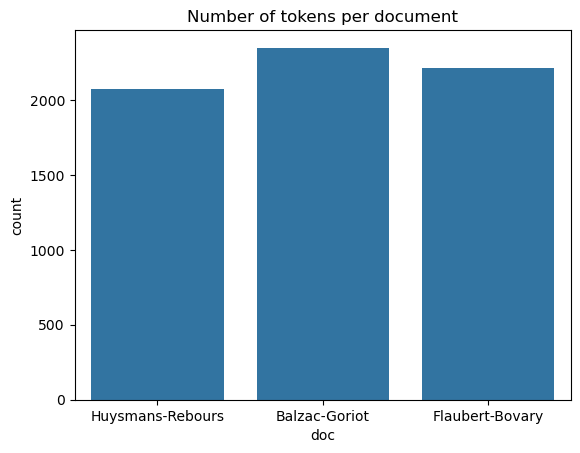

In [11]:
## Number of tokens per document
sns.countplot(pipeline.ngrams, x="doc")
plt.title("Number of tokens per document")

/opt/mamba/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


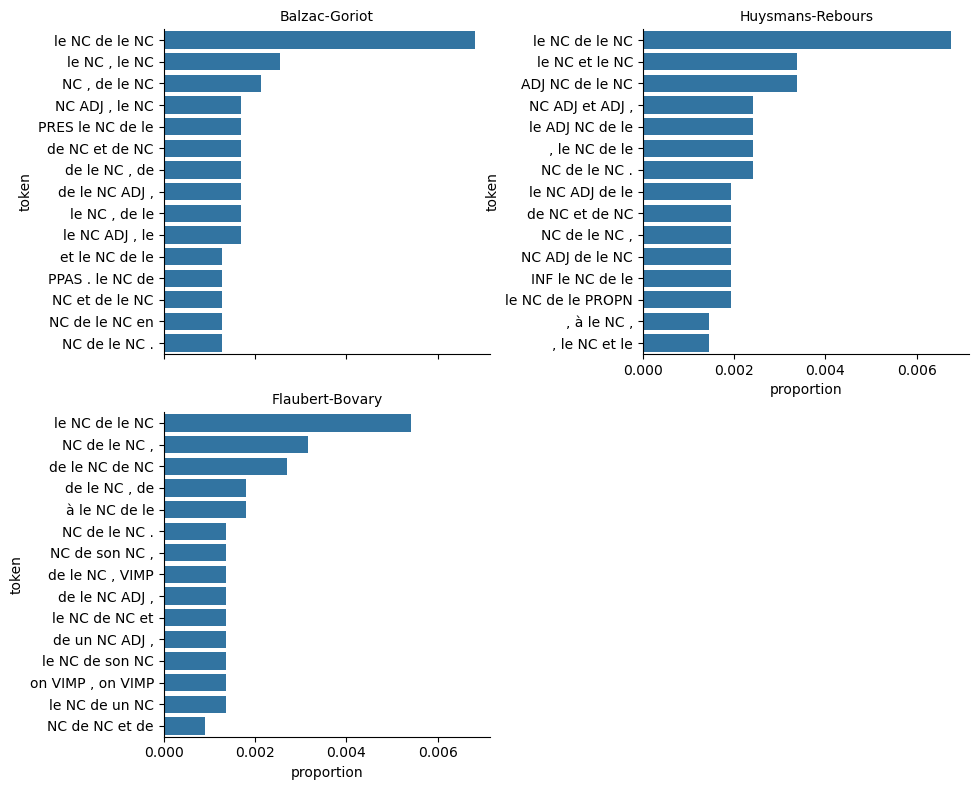

In [13]:
# Plot distribution of tokens separatly
plot_motif_histogram(pipeline.ngrams, stat="proportion", n_tokens=15, plot_type="sep")

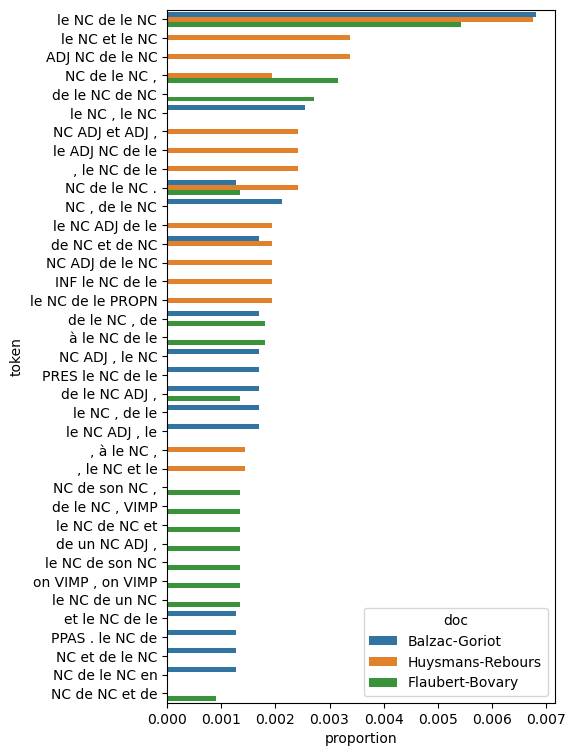

In [16]:
# Plot distribution of tokens grouped
plot_motif_histogram(pipeline.ngrams, stat="proportion", n_tokens=15, plot_type="group")

## Compute features (Tf-idf)

In this example, we use tf-idf features and we plot the most frequent ones

/Users/brunospilak/miniconda3/envs/pymotifs/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


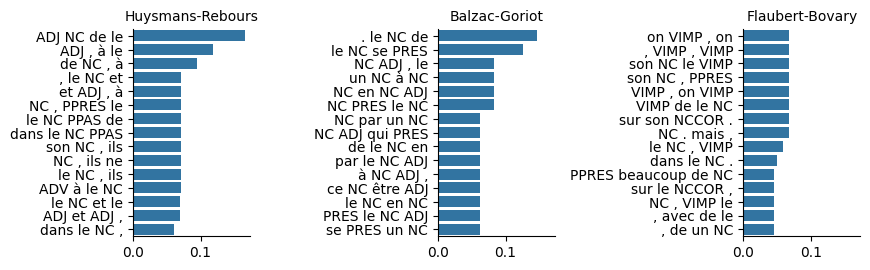

In [5]:
tfidf = pipeline.get_features(feature)
plot_tf_idf(tfidf, n_tokens=15, plot_type="sep")

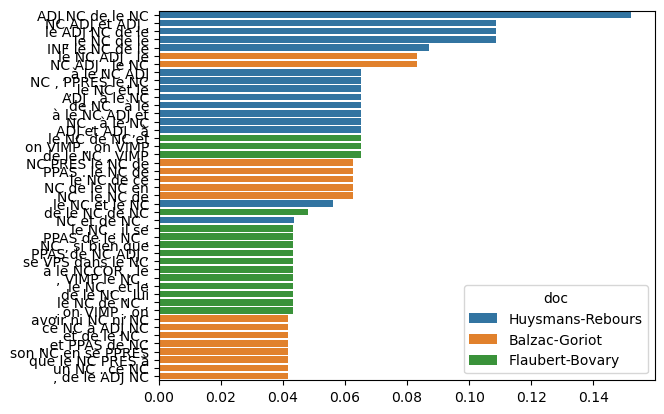

In [17]:
tfidf = pipeline.get_features(feature)
plot_tf_idf(tfidf, n_tokens=15, plot_type="group")

## Principal Component Analysis


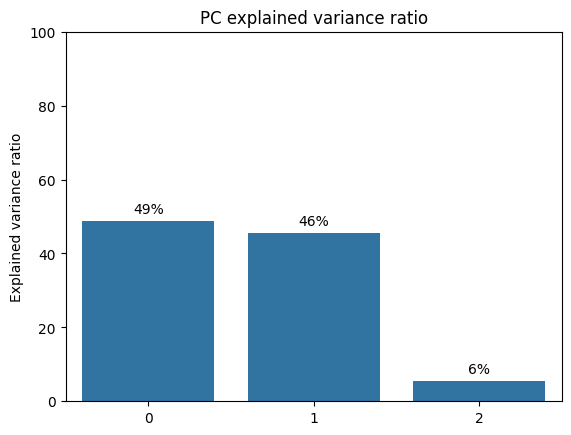

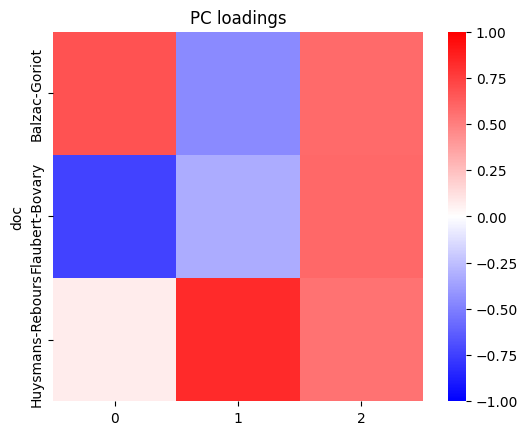

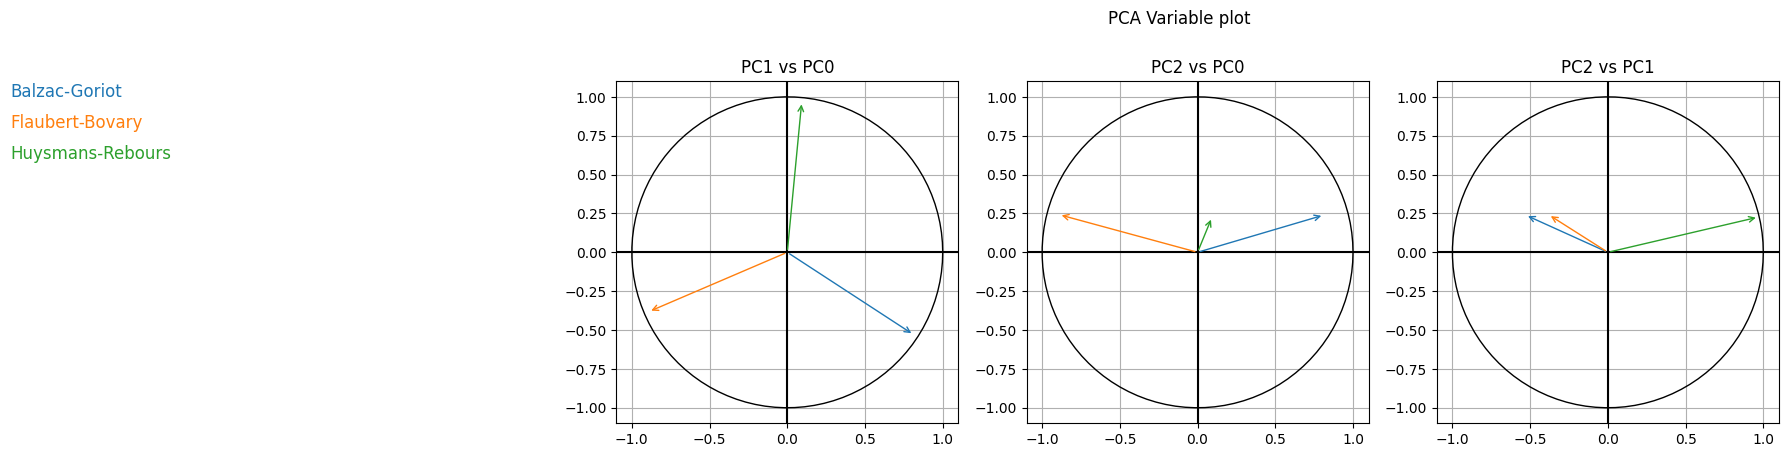

In [6]:
pca = pca_transform(
    tfidf.pivot_table(
        index="token", columns=["doc"], values=feature["name"]
    ), 
    plot=True
)

- We observe that the first two principal components (PC) explains 95% of the variance:
    - the first component explains both Flaubert-Bovary and Balzac-Goriot, but not Huysmans-Rebours
    - the second one explains very well Huysmans-Rebours
- Balzac-Goriot is positively correlated with the first PC
- Flaubert-Bovary is negatively correlated with the first PC
- Huysmans-Rebours is positvely correated with the second PC.
- Balzac-Goriot and Flaubert-Bovary are negatively correlated with the second PC.
- We observe that the first PC can be used to separate Flaubert-Bovary from Balzac-Goriot, while the second PC can be used to separate Huysmans-Rebours from Flaubert-Bovary and Balzac-Goriot.

## All in one

We can also execute the simple statistics, nb of words per document, frequencies, tf-idf and PCA in one call with the function `execute`

[PyMotifs-Logger:features.py:50] - [6325] - 2024-02-28 18:05:01 - DEBUG - Steps to go 2
[PyMotifs-Logger:features.py:50] - [6327] - 2024-02-28 18:05:02 - DEBUG - Steps to go 3
[PyMotifs-Logger:features.py:50] - [6328] - 2024-02-28 18:05:02 - DEBUG - Steps to go 1


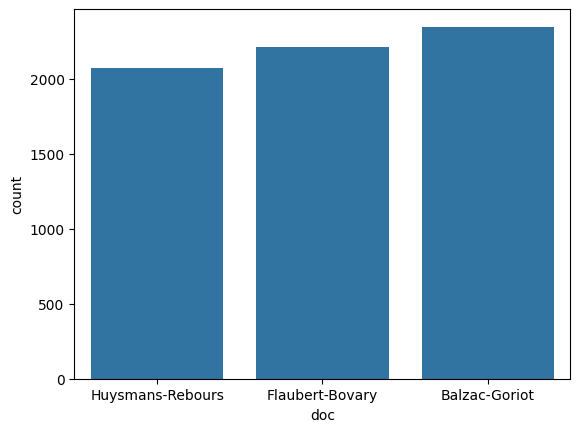

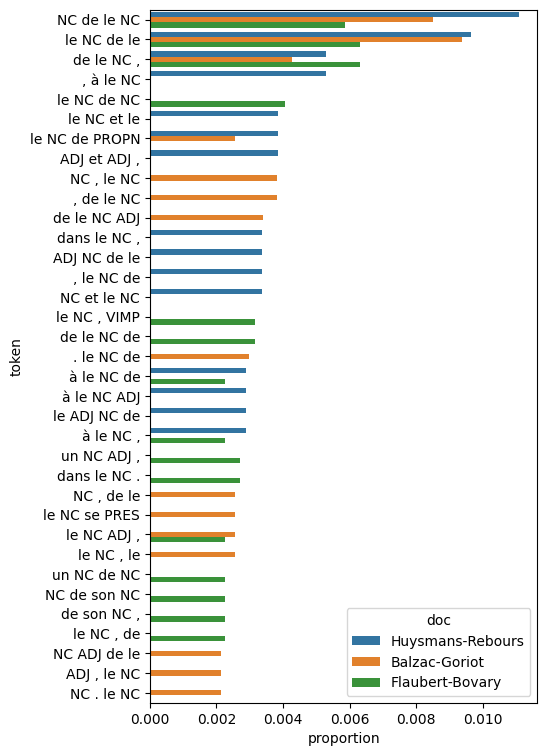

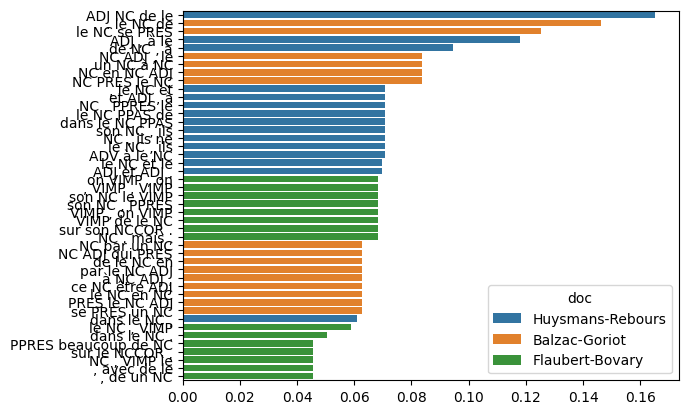

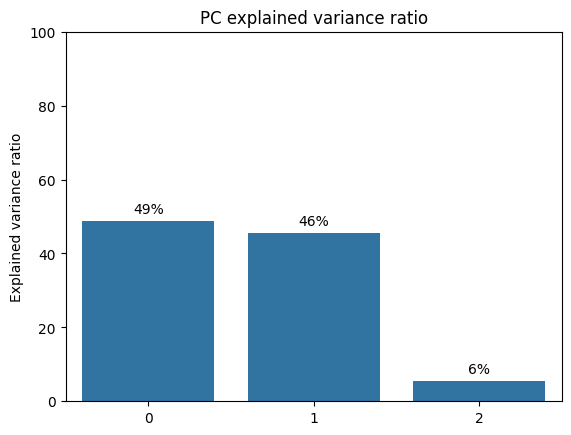

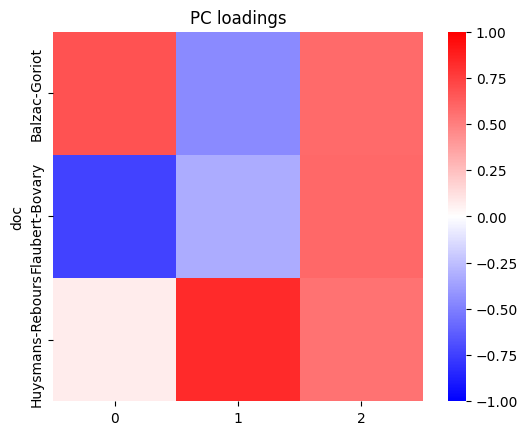

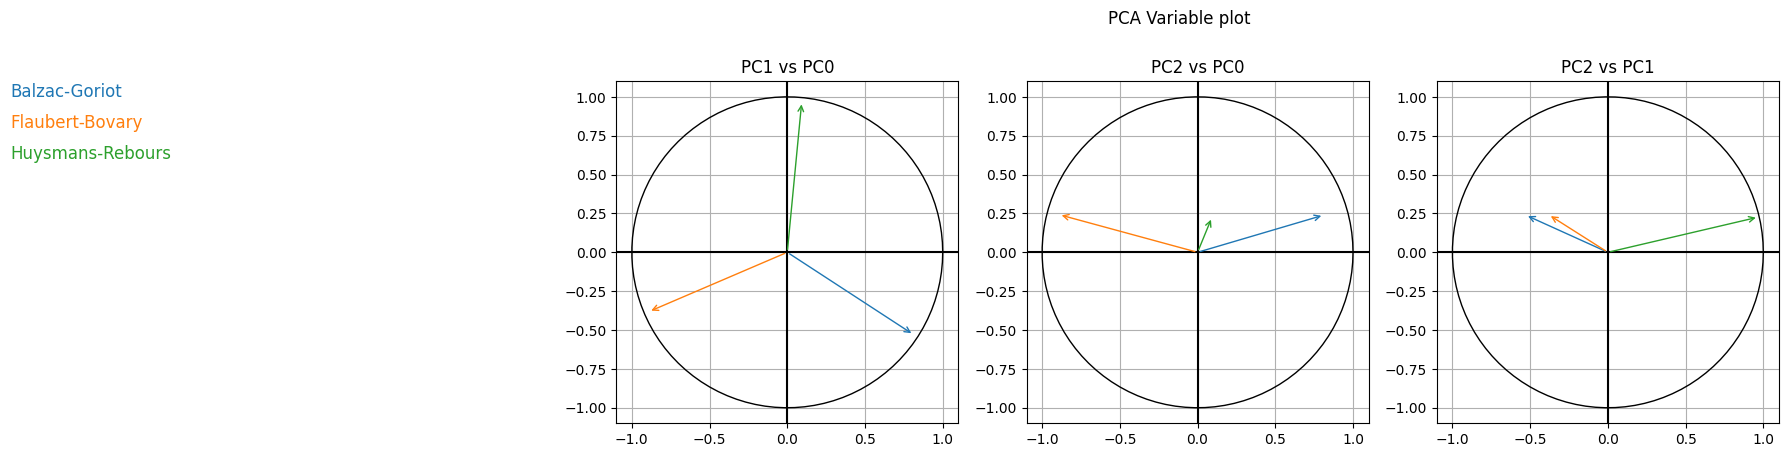

In [7]:
pipeline.execute(n=n, feature=feature, method="pca", plot=True, stat="proportion", n_tokens=15, plot_type="group")

## Specificity calculation

The specificity calculation is based on the work of Pierre Lafon ; it aims to "measures the expected or exceptional frequency of a word (or complex pattern, linguistic feature, etc.) in a part of the corpus, in relation to its frequency in the corpus as a whole and the size of the part. [...] The calculation is equivalent to listing all possible combinations of words in the different parts of the corpus, and evaluating the probability of each frequency according to the proportion of times it could theoretically be encountered if all combinations were equally possible. The test is therefore exact in that it directly and completely models the hypothesis of random distribution of words between parts." (see : https://shs.hal.science/halshs-03763801/file/pincemin_semantique-pur22_181127.pdf ; Lafon, Pierre, 1980, « Sur la variabilité de la fréquence des formes dans un corpus », _MOTS_, n°1, p. 127-165). The function `build_specificity` implement and do this specificity calculation.

In [22]:
from motifs.features import build_specificity
spec = build_specificity(pipeline.ngrams)

You can now navigate into the results of the calculation and perform different analysis :

- By selecting one document and select the n most frequent specificities of the opus (document level).
- By selecting the highest specificities within the all corpus (bottom-up analysis).
- By selecting one token (motif, pos, lemma or word) and see all its appearances in the corpus (top-down analysis).

### At the document level

In [31]:
# Show the 10 most specific tokens for Balzac-Goriot:
doc = "Balzac-Goriot"
spec.sort_values(by=[doc, "spec"], ascending=False).head(10)

,Balzac-Goriot,Flaubert-Bovary,Huysmans-Rebours,doc,f,t,spec,rel_f
token,,,,,,,,
"NC ADJ , le NC",1.804765,0.000000,0.000000,Balzac-Goriot,4,2348,1.804765,0.001704
"le NC ADJ , le",1.804765,0.000000,0.000000,Balzac-Goriot,4,2348,1.804765,0.001704
. le NC de ce,1.353394,0.000000,0.000000,Balzac-Goriot,3,2348,1.353394,0.001278
NC . le NC de,1.353394,0.000000,0.000000,Balzac-Goriot,3,2348,1.353394,0.001278
NC PRES le NC de,1.353394,0.000000,0.000000,Balzac-Goriot,3,2348,1.353394,0.001278
NC de le NC en,1.353394,0.000000,0.000000,Balzac-Goriot,3,2348,1.353394,0.001278
PPAS . le NC de,1.353394,0.000000,0.000000,Balzac-Goriot,3,2348,1.353394,0.001278
PRES le NC de le,1.250202,-0.881275,0.000000,Balzac-Goriot,4,2348,1.250202,0.001704
PRES le NC de le,1.250202,-0.881275,0.000000,Flaubert-Bovary,1,2212,-0.881275,0.000452


It seems that in Goriot, Balzac often starts a sentence with "le NC de". This motifs are highly specific to Balzac-Goriot with an index of 3.15 and appearing 7 times, respectively. It is not represented in Flaubert-Bovary or Huysmans-Rebours.

### At the corpus level (bottom-up analysis)

The function `return_to_text_from_spec` enables to select the highest specificities within the all corpus and give context and statistics based on the analysed tokens.

__N.B. :__ the parameters min_spec and min_freq are very important and should be used to minimize the number of results and the calculation time if you work with an important number of texts. If you need more information, see help(`return_to_text_from_spec`)

In [25]:
from motifs.utils import return_to_text_from_spec
import time
t1 = time.time()
context = return_to_text_from_spec(pipeline.ngrams, spec, n, context_len=10, min_spec=1, min_freq=2)
t2 = time.time()
print(t2-t1)
context

0.2617032527923584


,left_context,text,right_context,doc,spec,f,t
token,,,,,,,
ADJ NC de le NC,"yatagans , leur poitrine dont l' arc bombé rem...",énorme coquille de les cuirasses,. Ceux -là étaient les ancêtres ; les portrait...,Huysmans-Rebours,3.538804,7,2073
ADJ NC de le NC,", dans cette image de l' un de les plus",intimes familiers de le duc,"d' Épernon et de le marquis d' Ô , les",Huysmans-Rebours,3.538804,7,2073
ADJ NC de le NC,", dès qu' on s' efforça de lui apprendre les",premiers éléments de les sciences,. Sa famille se préoccupait peu de lui ; parfois,Huysmans-Rebours,3.538804,7,2073
ADJ NC de le NC,s' absorbait de nouveau dans la nuit factice d...,épais rideaux de les croisées,enveloppaient la chambre . Les domestiques éta...,Huysmans-Rebours,3.538804,7,2073
ADJ NC de le NC,"avenir , ils renoncèrent aussitôt à le diriger...",profitables carrières de les écoles,; bien qu' il discutât volontiers avec eux sur...,Huysmans-Rebours,3.538804,7,2073
...,...,...,...,...,...,...,...
"le NC , le NC",représentant l' Amour . À voir le vernis écail...,"la couvre , les amateurs",de symboles y découvriraient peut-être un myth...,Balzac-Goriot,-1.763371,1,2212
"le NC , le NC",il faudrait appeler l' odeur de pension . Elle...,"le renfermé , le moisi",", le rance ; elle donne froid , elle est",Balzac-Goriot,-1.763371,1,2212
"le NC , le NC","l' odeur de pension . Elle sent le renfermé ,","le moisi , le rance","; elle donne froid , elle est humide à le",Balzac-Goriot,-1.763371,1,2212


#### Corpus level (single document filter)

If you want to select one specific document within this table, you can execute the following function

In [53]:
context[context["doc"] == "Balzac-Goriot"] # replace Balzac-Goriot by the name of your targetted document

,left_context,text,right_context,doc,spec,f,t
token,,,,,,,
"NC ADJ , le NC",doit être . À la,"nuit tombante , la porte",à claire-voie est remplacée par,Balzac-Goriot,1.804765,4,2348
"NC ADJ , le NC",le mur mitoyen de la,"maison voisine , le long",de laquelle pend un manteau,Balzac-Goriot,1.804765,4,2348
"NC ADJ , le NC",". La , durant les","jours caniculaires , les convives",assez riches pour se permettre,Balzac-Goriot,1.804765,4,2348
"NC ADJ , le NC",à l' exploitation de la,"pension bourgeoise , le rez-de-chaussée",se compose d' une première,Balzac-Goriot,1.804765,4,2348
"le NC ADJ , le",le doit être . À,"la nuit tombante , la",porte à claire-voie est remplacée,Balzac-Goriot,1.804765,4,2348
"le NC ADJ , le",par le mur mitoyen de,"la maison voisine , le",long de laquelle pend un,Balzac-Goriot,1.804765,4,2348
"le NC ADJ , le","sièges . La , durant","les jours caniculaires , les",convives assez riches pour se,Balzac-Goriot,1.804765,4,2348
"le NC ADJ , le",destiné à l' exploitation de,"la pension bourgeoise , le",rez-de-chaussée se compose d' une,Balzac-Goriot,1.804765,4,2348
. le NC de ce,? le doute est permis,. Les particularités de cette,scène pleine d' observations et,Balzac-Goriot,1.353394,3,2348


### At the token level (top-down analysis)

If you have identified tokens or motifs of interest within the previous analysis and calculation (tf-idf, specificities), it can be useful to be able to get the context and the specificity score in which a token is being used. It can be done thanks to the `return_to_text_from_token` function. You first have to define which token of interest you want to analyze, select the context_length you want to display within the table and then run the function.

In [29]:
from motifs.utils import return_to_text_from_token
token = 'ADJ NC de le NC'
context_len = 5
context = return_to_text_from_token(pipeline.ngrams, token, n, context_len)
context

,left_context,text,right_context,doc,token
0,l' arc bombé remplissait l',énorme coquille de les cuirasses,. Ceux -là étaient les,Huysmans-Rebours,ADJ NC de le NC
1,l' un de les plus,intimes familiers de le duc,d' Épernon et de le,Huysmans-Rebours,ADJ NC de le NC
2,efforça de lui apprendre les,premiers éléments de les sciences,. Sa famille se préoccupait,Huysmans-Rebours,ADJ NC de le NC
3,la nuit factice dont les,épais rideaux de les croisées,enveloppaient la chambre . Les,Huysmans-Rebours,ADJ NC de le NC
4,à le diriger sur les,profitables carrières de les écoles,; bien qu' il discutât,Huysmans-Rebours,ADJ NC de le NC
5,"arrière- grand-oncle Dom Prosper ,",ancien prieur de les chanoines,réguliers de Saint-Ruf . Le,Huysmans-Rebours,ADJ NC de le NC
6,"les anciens preux , les",dernières branches de les races,"féodales , apparurent à de",Huysmans-Rebours,ADJ NC de le NC


## Experimental (beta) : coocurrence analysis

Coocurrence calculation is quite well known today in data analysis (lexicometry, textometry). However, in our context, since we're working on ngrams of patterns that overlap one another, the study of competition can often come down to a study of collocation or patterns that clump together rather than "coocurve".

The analysis of cooccurrence is done at a context level. Thus we must transform the n-grams text into windows of n-grams of arbitrary length. For this, we use the `build_window_corpus`. For example, we can set the context length to 2 to check the immediate coocurrence (left and right).

Then we find the cooccurrent tokens with `find_cooccurrent_token`. Here again, we have three ways to explore coocurrence : 

- At the motif / token level (`find_cooccurrent_token`)
- At the corpus level (`corpus_cooccurrent_tokens`)
- At the document level (`find_top_n_cooccurrence(windows[windows.doc == doc], 5)`

## Motif / token level 

In [35]:
help(find_cooccurrent_tokens)

Help on function find_cooccurrent_tokens in module motifs.metrics:

find_cooccurrent_tokens(token: str, data: pandas.core.frame.DataFrame, n: int, by: str = 'window') -> pandas.core.frame.DataFrame
    Returns the top n cooccurrent tokens of the input token in a top down
    fashion.
    :param token:
    :param data: DataFrame with columns ["token", by]
    :param n: Maximum number of cooccurrence to return
    :param by: Name of the variable defining the window on which the
    cooccurrence is computed
    :return: a DataFrame with columns ["token", "count"]



In [47]:
# Transform to context data frame
from motifs.utils import build_window_corpus
from motifs.metrics import find_cooccurrent_tokens

windows = build_window_corpus(pipeline.ngrams, 3)

# Within a single text and based on a specific token or motif
doc = "Balzac-Goriot" # document of interest 
token = "le NC , le NC"
tokens = find_cooccurrent_tokens(
    token, windows[windows.doc == doc], n = 30
)
tokens

,target,token,count
0,"le NC , le NC","qui le NC , le",1


## Corpus level

We can also check the cooccurrence of the motif at the corpus level without filtering, using `corpus_cooccurrent_tokens`

In [48]:
# At the corpus level
from motifs.metrics import corpus_cooccurrent_tokens
cooccurent_tokens = corpus_cooccurrent_tokens(token, windows, 10)
cooccurent_tokens

,target,token,count,doc
0,"le NC , le NC","qui le NC , le",1,Balzac-Goriot


## Document level

Finally, we can also analyse the results at the document level.

In [49]:
# Within a single text
from motifs.metrics import find_top_n_cooccurrence
cooc = find_top_n_cooccurrence(windows[windows.doc == doc], 5)
cooc

,token1,token2,count
0,", le NC , le","le NC , le NC",2
1,"ADJ , à NC ADJ","NC ADJ , à NC",2
2,"ADJ , de le NC","NC ADJ , de le",2
3,"NC ADJ , le NC","le NC ADJ , le",3
4,"de le NC , de","le NC , de le",3
